In [1]:
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and 
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # image = (image - mean) / std
     ])

batchSize = 200

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

examplesCnt = 8 # how many images with ground truth/prediction shall be printed?

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



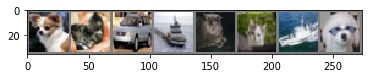

  dog   cat   car  ship   cat   cat  ship   dog


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)

images, labels = dataiter.next()
images = images[0:examplesCnt]
labels = labels[0:examplesCnt]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(examplesCnt)))

2. Define a Convolutional Neural Network

Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [ ]:
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [ ]:
def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model

In [ ]:


# use cuda device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(torch.cuda.get_device_name(0))
print(device)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv2d: input, output, kernel size, (stride=1, padding=0)
        self.conv1 = nn.Conv2d(3, 48, 5) # 3 input image channel, 48 output channels, 5x5 square convolution
        self.conv2 = nn.Conv2d(48, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # 10 classses output

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # conv results in 28x28 (image-kernel+1), pool => 14x14
        x = self.pool(F.relu(self.conv2(x))) # conv results in 10x10 (image-kernel+1), pool => 5x5
        #print(x.shape)
        x = x.view(-1, 32 * 5 * 5)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


net = resnet34().to(device)

GeForce GTX 980 Ti
cuda


3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9) # ToDo!
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=100, verbose=True, threshold=0.03 )

4. Train the network


This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
import time

time_start = time.process_time()

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) # 10 class output
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        # print statistics
        running_loss += loss.item()
        if i % 25 == 24:    # print every 25 mini-batches of size 200
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 25))
            running_loss = 0.0

print('Finished Training (duration %.3f sec)' % (time.process_time() - time_start))


tensor(2.6326, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(3.9806, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(4.5311, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(5.5481, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(6.3262, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(7.0907, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(6.0508, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(6.2745, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(3.9550, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(3.5689, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(4.1696, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(3.8542, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(3.4779, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(3.5960, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.7104, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(3.1967, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(3.2969, device='cuda:0', grad_fn=<NllLossBackward

tensor(1.9496, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7760, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8622, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9855, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7595, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2262, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0094, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6714, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6793, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7178, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6324, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5877, device='cuda:0', grad_fn=<NllLossBackward>)
[1,   150] loss: 1.908
tensor(2.1652, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9698, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7178, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7897, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8123, device='cuda:0', g

tensor(1.8627, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6735, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8822, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7201, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5074, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8837, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6360, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7254, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6397, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8095, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6840, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5977, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6404, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4247, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5626, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7695, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7321, device='cuda:0', grad_fn=<NllLossBackward

tensor(1.4906, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4546, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3574, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4124, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4548, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4950, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2796, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5108, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3962, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6285, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3642, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3872, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5924, device='cuda:0', grad_fn=<NllLossBackward>)
[2,   175] loss: 1.485
tensor(1.5454, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5500, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5124, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3760, device='cuda:0', g

tensor(1.4945, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3772, device='cuda:0', grad_fn=<NllLossBackward>)
[3,    50] loss: 1.388
tensor(1.2757, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4504, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2029, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2685, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3133, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3546, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4573, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3597, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2806, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2762, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3706, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2777, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2682, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4282, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3921, device='cuda:0', g

tensor(1.3910, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3777, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4493, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3725, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4427, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4394, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3794, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3998, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2301, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3853, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2853, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3353, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3657, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4542, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4221, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3427, device='cuda:0', grad_fn=<NllLossBackward>)
[3,   200] loss: 1.361
tensor(1.2973, device='cuda:0', g

tensor(1.6549, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3768, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4106, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2905, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3937, device='cuda:0', grad_fn=<NllLossBackward>)
[4,    75] loss: 1.382
tensor(1.3931, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2864, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4614, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3619, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2914, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3993, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3463, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4079, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3021, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3225, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2689, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4826, device='cuda:0', g

tensor(1.5328, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3017, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3899, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3566, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3909, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3904, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4418, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2886, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3827, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2273, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2790, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3876, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2716, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3603, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3581, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4563, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2876, device='cuda:0', grad_fn=<NllLossBackward

tensor(1.3412, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3429, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4052, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.1972, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5020, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3694, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2954, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3767, device='cuda:0', grad_fn=<NllLossBackward>)
[5,   100] loss: 1.358
tensor(1.2515, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3908, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2768, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2879, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4330, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3681, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4506, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4599, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3930, device='cuda:0', g

5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images = images[0:examplesCnt]
labels = labels[0:examplesCnt]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(examplesCnt)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
# move input to cuda device if available
images = images.to(device)

outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(examplesCnt)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))